##### Most of the codes below are copied from '01.mnist_softmax.py'

In [3]:
import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import tensorflow as tf
import numpy as np
import exp_util as exp
from tensorflow import keras
import sklearn.metrics as sk
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Define simple model. execution starts from the bottom
def basic_mnist_model():

    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(28, 28)),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(256, activation=tf.nn.relu),

        keras.layers.BatchNormalization(),
        keras.layers.Dense(256, activation=tf.nn.relu),

        keras.layers.BatchNormalization(),
        keras.layers.Dense(256, activation=tf.nn.relu),

        keras.layers.BatchNormalization(),
        keras.layers.Dense(10, activation=tf.nn.softmax)
    ])

    return model

In [5]:
# Load MNIST, FMNIST dataset
mnist = keras.datasets.mnist
(mnist_train_x, mnist_train_y), (mnist_test_x, mnist_test_y)\
    = mnist.load_data()
mnist_train_x, mnist_test_x = mnist_train_x/255., mnist_test_x/255.

fashion_mnist = keras.datasets.fashion_mnist
(fmnist_train_x, fmnist_train_y), (fmnist_test_x, fmnist_test_y)\
    = fashion_mnist.load_data()
fmnist_train_x, fmnist_test_x = fmnist_train_x/255., fmnist_test_x/255.

In [6]:
# Train model if no pre-trained model exists
saved_model_path = './mnist.hdf5'
if not os.path.exists(saved_model_path):

    model = basic_mnist_model()

    # TRAIN MODEL
    training_epochs = 10
    learning_rate = 0.001
    batch_size = 128

    model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(mnist_train_x, mnist_train_y,
              epochs=training_epochs,
              batch_size=batch_size)

    test_loss, test_acc = model.evaluate(mnist_test_x, mnist_test_y)
    print("Training done, test accuracy: {}".format(test_acc))

    # SAVE MODEL
    keras.models.save_model(model, "./mnist.hdf5")

else:
    model = keras.models.load_model(saved_model_path)

Epoch 1/10
60000/60000 [==============================] - 6s 105us/step - loss: 0.2065 - acc: 0.9359
Epoch 2/10
60000/60000 [==============================] - 5s 76us/step - loss: 0.0809 - acc: 0.9743
Epoch 3/10
60000/60000 [==============================] - 5s 75us/step - loss: 0.0512 - acc: 0.9834
Epoch 4/10
60000/60000 [==============================] - 5s 78us/step - loss: 0.0400 - acc: 0.9866
Epoch 5/10
60000/60000 [==============================] - 5s 78us/step - loss: 0.0297 - acc: 0.9903
Epoch 6/10
60000/60000 [==============================] - 5s 79us/step - loss: 0.0282 - acc: 0.9906
Epoch 7/10
60000/60000 [==============================] - 5s 76us/step - loss: 0.0245 - acc: 0.9919
Epoch 8/10
60000/60000 [==============================] - 5s 76us/step - loss: 0.0214 - acc: 0.9928
Epoch 9/10
60000/60000 [==============================] - 5s 76us/step - loss: 0.0204 - acc: 0.9928
Epoch 10/10
10000/10000 [==============================] - 1s 58us/step
Training done, test accurac

In [7]:
# right/wrong distinction, regarding correct examples as positive
s_prob_right, s_prob_wrong, kl_right, kl_wrong =\
    exp.right_wrong_distinction(model, mnist_test_x, mnist_test_y)

# In-Out-of-distribution test, assumes out-of-distribution samples as negative
s_prob_in_f, s_prob_out_f, kl_in_f, kl_out_f =\
    exp.in_out_distinction(model, mnist_test_x, fmnist_test_x, "FashionMNIST")

s_prob_in_w, s_prob_out_w, kl_in_w, kl_out_w =\
    exp.in_out_distinction(model, mnist_test_x, np.random.normal(size=(10000, 28, 28)), "WhiteNoise")

s_prob_in_u, s_prob_out_u, kl_in_u, kl_out_u =\
    exp.in_out_distinction(model, mnist_test_x, np.random.uniform(size=(10000, 28, 28)), "UniformNoise")


[MNIST SUCCESS DETECTION]
MNIST Error (%)| Prediction Prob (mean, std) | PProb Right            (mean, std) | PProb Wrong (mean, std):
2.18999981880188 | 0.9899579 0.052967437 | 0.9940217 0.037173312 | 0.80846 0.1808637
Success base rate (%): 97.81 (9781/10000)
KL[p||u]: Right/Wrong classification distinction
AUPR (%): 99.91
AUROC (%): 96.42
Prediction Prob: Right/Wrong classification distinction
AUPR (%): 99.91
AUROC (%): 96.41

Error Detection
Error base rate (%): 2.19 (219/10000)
AUPR (%): 44.26
AUROC (%): 96.42
Prediction Prob: Right/Wrong classification distinction
AUPR (%): 44.85
AUROC (%): 96.41

[MNIST-FashionMNIST anomaly detection]
In-dist max softmax distribution (mean, std):
0.9899579 0.052967437
Out-of-dist max softmax distribution(mean, std):
0.91532385 0.14896864

Normality Detection
Normality base rate (%): 50.0
KL[p||u]: Normality Detection
AUPR (%): 68.46
AUROC (%): 76.07
Prediction Prob: Normality Detection
AUPR (%): 69.86
AUROC (%): 76.32

Abnormality Detection
Abn

In [8]:
# Bind right/wrong distinction result
sp_rw = [s_prob_right, s_prob_wrong]
kl_rw = [kl_right, kl_wrong]

# Bind in/out of distribution detecting result of MNIST-FashionMNIST
sp_iof = [s_prob_in_f, s_prob_out_f]
kl_iof = [kl_in_f, kl_out_f]

# Bind in/out of distribution detecting result of MNIST-WhiteNoise
sp_iow = [s_prob_in_w, s_prob_out_w]
kl_iow = [kl_in_w, kl_out_w]

# Bind in/out of distribution detecting result of MNIST-UniformNoise
sp_iou = [s_prob_in_u, s_prob_out_u]
kl_iou = [kl_in_u, kl_out_u]

targets = [('right/wrong', sp_rw),
           ('in/out, MNIST/FashionMNIST', sp_iof),
           ('in/out, MNIST/WhiteNoise', sp_iow),
           ('in/out, MNIST/UniformNoise', sp_iou),
           ('right/wrong', kl_rw), 
           ('in/out, MNIST/FashionMNIST', kl_iof), 
           ('in/out, MNIST/WhiteNoise', kl_iow), 
           ('in/out, MNIST/UniformNoise', kl_iou)]

In [9]:
def safe_risky_to_roc_curve(safe, risky, inverse=False):
    labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
    if inverse:
        labels[safe.shape[0]:] += 1
    else:
        labels[:safe.shape[0]] += 1
    examples = np.squeeze(np.vstack((safe, risky)))
    aupr = round(100*sk.average_precision_score(labels, examples), 2)
    auroc = round(100*sk.roc_auc_score(labels, examples), 2)
    fpr, tpr, _ = sk.roc_curve(labels, examples)
    return fpr, tpr, aupr, auroc

<Figure size 432x288 with 0 Axes>

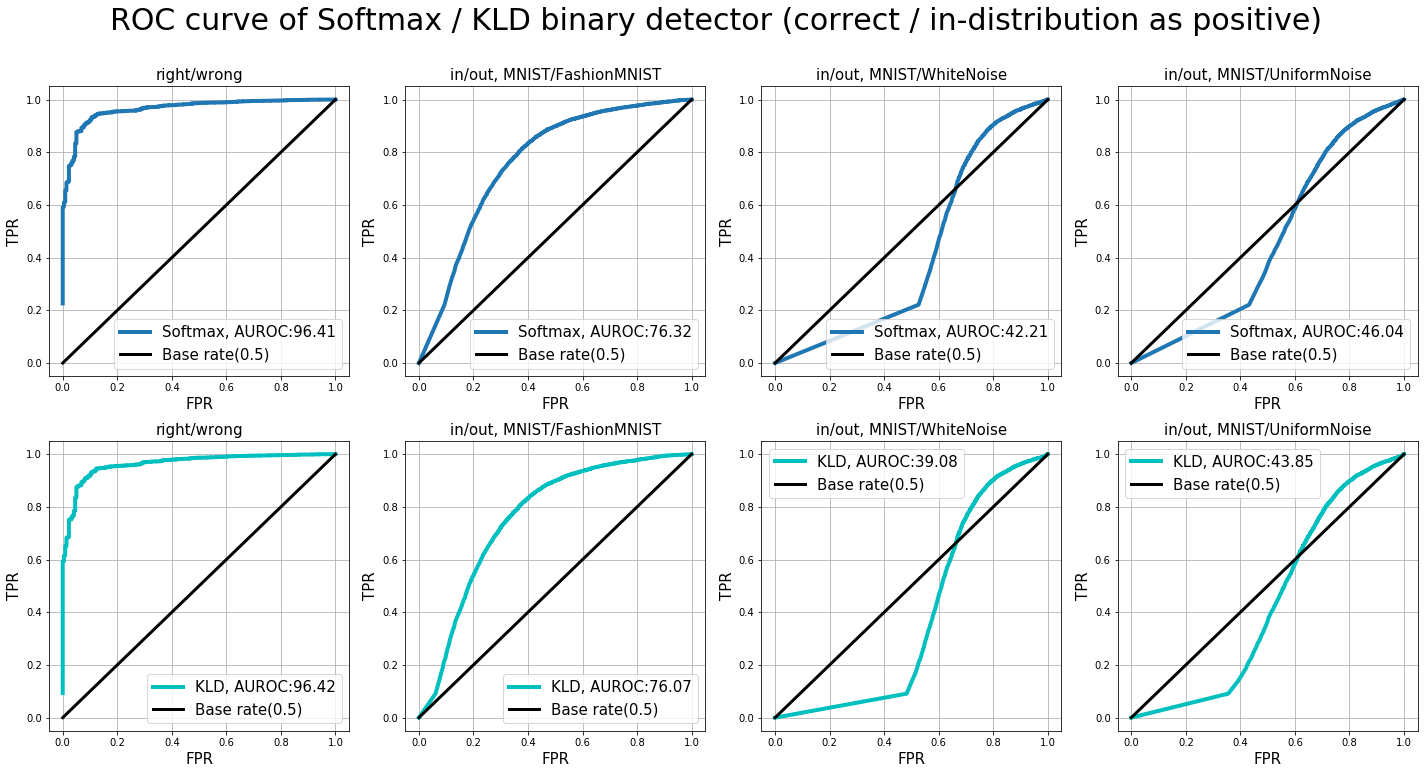

In [10]:
rows, cols = 2, 4
fz = 15

plt.tight_layout()
plt.figure(figsize=(20,10))
plt.suptitle('ROC curve of Softmax / KLD binary detector (correct / in-distribution as positive)', y=1.07, fontsize=30)

for i, (plotname, (safe, risky)) in enumerate(targets):
    
    plt.subplot(2, 4, i+1)
    plt.tight_layout()
    fpr, tpr, aupr, auroc = safe_risky_to_roc_curve(safe, risky)
    plt.plot(fpr, tpr,
             '-' if i < 4 else 'c-',
             label='Softmax, AUROC:{}'.format(auroc) if i < 4 else 'KLD, AUROC:{}'.format(auroc),
             lw=4)
    plt.plot([0, 1], 'k-', lw=3, label='Base rate(0.5)')
    plt.legend(fontsize=fz)
    plt.title(plotname, fontsize=fz)
    plt.xlabel("FPR", fontsize=fz)
    plt.ylabel("TPR", fontsize=fz)
    plt.grid(True)